# EEGNet with xDawn
Exploring Riemannian classifiers, it is clear that xDawn improves significantly the performance of the SVM classifier on the tangent space of SPD.<br>
Reading more about xDawn, I discovered that it is good on processing overlapping data, something that is a core characteristic of THINGS-EEG.<br>
Therefore, in this notebook I will study the behaviour of eegnet on xDAWN preprocessed data aiming to improve its performance on THINGS-EEG.<br>
I will explore its behaviour on other datasets eventually.

In [1]:
#Lib
import sys
sys.path.append("/home/rffl/files/eegconv/k-class")
sys.path.append("/home/rffl/files/eegconv/")

import pyriemann as rmn
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import kclass_lsubgen
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import eegnet # type: ignore
import kclassdataset

# parameters
classvec = [i+1 for i in range(5)]
subvec = [i+1 for i in range(10)]
xDAWNfilters = 5
estimator = "lwf"

## Data generation and processing

In [14]:
train_path, test_path = kclass_lsubgen.generatedataset(classvec, subvec, 0.75, False)
X_train = np.load(train_path, allow_pickle=True)
X_test = np.load(test_path, allow_pickle=True)

# generate target
y_train = np.array([])
part = len(X_train) // len(classvec)
for i in range(len(classvec)):
    y_train = np.concatenate([y_train, i * np.ones(part, dtype=np.int64)])

y_test = np.array([])
part = len(X_test) // len(classvec)
for i in range(len(classvec)):
    y_test = np.concatenate([y_test, i * np.ones(part, dtype=np.int64)])

# xDawn
xdawn = rmn.estimation.Xdawn(nfilter=xDAWNfilters, estimator=estimator)
X_train = xdawn.fit_transform(X_train, y_train)
X_test = xdawn.transform(X_test)
np.save(train_path, X_train )
np.save(test_path, X_test )

trainDataset = kclassdataset.KClassDataset(len(classvec), train_path)
trainLoader = DataLoader(trainDataset, 12, True, num_workers=3)

testDataset = kclassdataset.KClassDataset(len(classvec), test_path)
testLoader = DataLoader(testDataset, 12, True, num_workers=3)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Saved ./kclass-lsubtrain.npy shape = (3000, 17, 100)
Saved ./kclass-lsubtest.npy shape = (1000, 17, 100)
X_train shape: (3000, 25, 100)
X_test shape: (1000, 25, 100)


## Training

Epoch 1: Train loss 1.6214, acc 0.1960 | Test loss 1.6037, acc 0.2200
Epoch 2: Train loss 1.6005, acc 0.2377 | Test loss 1.5897, acc 0.2910
Epoch 3: Train loss 1.5895, acc 0.2490 | Test loss 1.5775, acc 0.3020
Epoch 4: Train loss 1.5750, acc 0.2747 | Test loss 1.5577, acc 0.3200
Epoch 5: Train loss 1.5658, acc 0.2773 | Test loss 1.5426, acc 0.3380
Epoch 6: Train loss 1.5604, acc 0.2793 | Test loss 1.5393, acc 0.3410
Epoch 7: Train loss 1.5583, acc 0.2933 | Test loss 1.5283, acc 0.3660
Epoch 8: Train loss 1.5515, acc 0.3027 | Test loss 1.5224, acc 0.3870
Epoch 9: Train loss 1.5399, acc 0.3060 | Test loss 1.5144, acc 0.3760
Epoch 10: Train loss 1.5374, acc 0.3143 | Test loss 1.5105, acc 0.3930
Epoch 11: Train loss 1.5378, acc 0.3160 | Test loss 1.5155, acc 0.3790
Epoch 12: Train loss 1.5356, acc 0.3063 | Test loss 1.5033, acc 0.3860
Epoch 13: Train loss 1.5363, acc 0.3150 | Test loss 1.5056, acc 0.3830
Epoch 14: Train loss 1.5230, acc 0.3180 | Test loss 1.4916, acc 0.3900
Epoch 15: Train

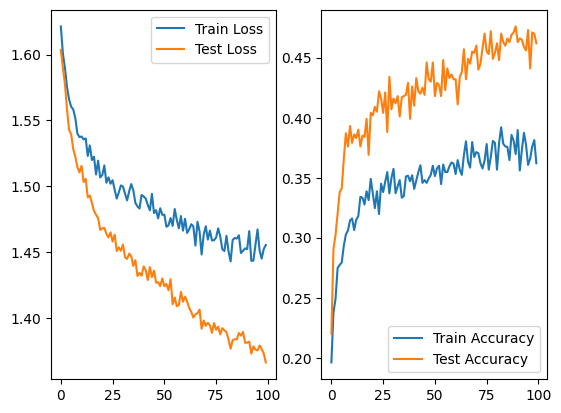

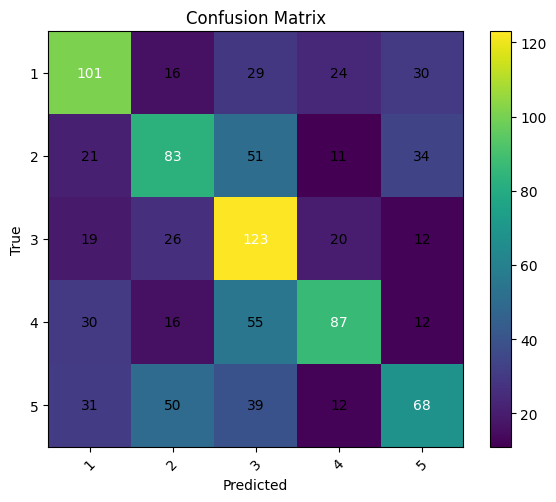

In [16]:
eegnet.regular_train(25, 100, 100, len(classvec), trainLoader, testLoader, 100, False, classvec)